Functional Discourse Grammar is normally used to describe the production of spoken language in a way that is comparable across widely differing languages. Can we define a notation informed by FDG to describe the structure of a transformer model?

The features of such a notation include:
* Describe a discourse, not just a sentence
* Utterances are described in parallel at a number of levels, which are completed in parallel as the sentence is completed.  There are links between the levels, FDG describes 4 levels, including the phonological layer which is less relevant to text proessing. Lower levels follow the actual word ordering more closely, upper levels may not be completed out of order. 
* Each level has a hierarchically ordered layered organization. 
* Layers always have a head, and usually a modifier (both of which may themselves be layers or lexical content), and may also be specified by a linguistic-operator and carry a linguistic-function.

Challenges include similar terminology with quiet distinct meanings.In particular the use of layer and function in FDG may lead to confusion, I will attempt to be specific in referring to linguistic-layer and transformer-layers.

A key difference between transformer language models and typical FDG tasks is that FDG is focussed primarily on the formulation of speech rather than language interpretation, while generative language models both intepret and formulate language, with an indistinct boundary between the two. I expect the first and last layers to remain close to morphosyntactic representation, and internal transformer-layers to be reflect the interpersonal and representational linguistic-levels.

I do not propose trying to train a network to interpret an utterance using FDG - I am sure this would be possible since analysis using more widely used linguistic representations are already possible. I am more interested in what parallels there may be between the structure of the transformer latent space and the structure of FDG

My understanding of the transformer architecture is that the token generated depends on a transformation of the same position in a lower transformer-level, and through attention heads on other positions in the same level. (describe this more rigorously...)

The idea is to identify elements that span multiple consecutive positions within a transformer-layer based on 
a) identifying sets of neurons that have been  significant to later positions
b) identifying how long those neurons remain active 
c) where they came from (previous history or lower layers)

step down through levels to identify where certain activation patterns were introduced, then search across to identify which positions in history at that level contributed. These are then treated as starting points on that layer.






In [1]:
from transformer_utils.low_memory import enable_low_memory_load
import transformers

enable_low_memory_load()
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
model = transformers.AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-125M')


c:\users\stephenprior\.virtualenvs\transformer-utils-kjd8b5rh\lib\site-packages\torch\nn\modules\lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Embeds 50,257 BPE vocab tokens to 768-dimensional latent space.

In [2]:
model.transformer.wte

Embedding(50257, 768)

Embeds 2048 token positions to 768-dimensional latent space.

In [3]:
model.transformer.wpe

Embedding(2048, 768)

In [4]:
model.transformer.h[0]

GPTNeoBlock(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPTNeoAttention(
    (attention): GPTNeoSelfAttention(
      (attn_dropout): Dropout(p=0, inplace=False)
      (resid_dropout): Dropout(p=0, inplace=False)
      (k_proj): Linear(in_features=0, out_features=768, bias=False)
      (v_proj): Linear(in_features=0, out_features=768, bias=False)
      (q_proj): Linear(in_features=0, out_features=768, bias=False)
      (out_proj): Linear(in_features=0, out_features=768, bias=True)
    )
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPTNeoMLP(
    (c_fc): Linear(in_features=0, out_features=3072, bias=True)
    (c_proj): Linear(in_features=0, out_features=768, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
)

In [5]:
import torch
def text_to_input_ids(text):
    toks = tokenizer.encode(text)
    return torch.as_tensor(toks).view(1, -1).cuda()

In [6]:
from transformer_utils.partial_forward import partial_forward


In [7]:

input_ids = text_to_input_ids("Watch out, because there is a bull in the field. Don't")


In [8]:
input_ids

tensor([[10723,   503,    11,   780,   612,   318,   257,  6473,   287,   262,
          2214,    13,  2094,   470]], device='cuda:0')

In [9]:
tokenizer.batch_decode(input_ids)

["Watch out, because there is a bull in the field. Don't"]

In [10]:
tokenizer.decode(10723)

'Watch'

In [11]:
input_ids.shape

torch.Size([1, 14])

In [12]:
    output_names=['h.0', 'h.1','h.2','h.3', 'h.4','h.5','h.6', 'h.7','h.8','h.9','h.10','h.11']
    with torch.no_grad():
        hidden_states = partial_forward(
            model.base_model,
            output_names,
            input_ids,
        )
    hidden_states['h.11'].shape

torch.Size([1, 14, 768])

In [13]:
    hidden_states['h.11'][0][0].shape

torch.Size([768])

In [14]:

    
torch.linalg.norm(hidden_states['h.11'][0][0]).cpu().numpy()

array(200.0554, dtype=float32)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np



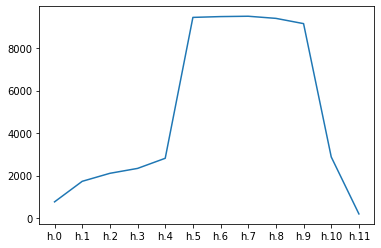

In [16]:
#plot the norm of hidden states across layers for first word 
def norm(layer):
    return torch.linalg.norm(hidden_states[layer][0][0]).cpu().numpy()

norms = list(map(norm,output_names))
plt.plot(output_names,norms)



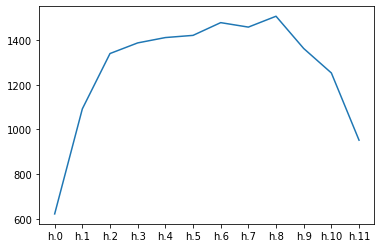

In [17]:
#plot the norm of hidden states across layers for second word (later ones are fairly similar)

def norm(layer):
    return torch.linalg.norm(hidden_states[layer][0][1]).cpu().numpy()

norms = list(map(norm,output_names))
plt.plot(output_names,norms)

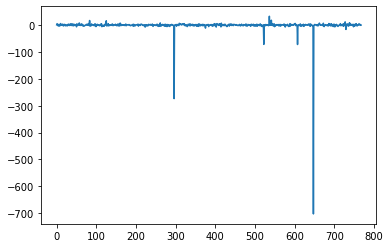

In [18]:
#hidden state waveform for first word
plt.plot(hidden_states['h.0'][0][0].cpu().numpy())



In [19]:
tokenizer.decode(10723)

'Watch'

In [20]:
tokenizer.encode('Watch')

[10723]

In [21]:
last_layer_normed = model.base_model.ln_f(hidden_states['h.11'][0])
all_logits = model.lm_head(last_layer_normed)

In [22]:
logits=all_logits[0]

In [23]:
logits.shape, logits

(torch.Size([50257]),
 tensor([ -3.3300,  -2.4929,  -7.4483,  ..., -14.6817, -10.4255,  -5.0853],
        device='cuda:0', grad_fn=<SelectBackward>))

In [24]:
torch.argmax(logits)

tensor(278, device='cuda:0')

In [25]:
torch.argmax(last_layer_normed[0])

tensor(486, device='cuda:0')

In [26]:
tokenizer.decode(485)

'ide'

In [27]:
model

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=0, out_features=768, bias=False)
            (v_proj): Linear(in_features=0, out_features=768, bias=False)
            (q_proj): Linear(in_features=0, out_features=768, bias=False)
            (out_proj): Linear(in_features=0, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=0, out_features=3072, bias=True)
          (c_proj): Linear(in_features=0, out_features=7

In [28]:
with torch.no_grad():    
    y = model.forward(input_ids,output_attentions=True,
        output_hidden_states=True,
        return_dict=True)

y

CausalLMOutputWithPast(loss=None, logits=tensor([[[ -3.3300,  -2.4929,  -7.4483,  ..., -14.6817, -10.4255,  -5.0853],
         [ -0.0507,  -5.2973, -10.6778,  ..., -15.0821, -11.9509,  -6.5869],
         [ -5.7390,  -6.8029,  -9.7417,  ..., -13.3648, -11.1025,  -7.3311],
         ...,
         [ -7.7671,  -5.1437,  -7.8700,  ..., -21.8658, -13.1095,  -1.5508],
         [ -8.2493,  -6.0710, -12.2007,  ..., -23.3041, -18.3014,  -9.1534],
         [ -5.3456,  -8.2189, -13.6079,  ..., -13.1011, -16.0331,  -7.2978]]],
       device='cuda:0'), past_key_values=((tensor([[[[ 3.0395e-01,  2.8227e-01,  2.5899e-01,  ...,  3.6717e-02,
            1.5334e-01, -7.2069e-02],
          [ 4.2654e-01,  4.2869e-01,  5.2565e-01,  ..., -1.5126e-01,
           -1.5136e-01,  1.9724e-01],
          [ 1.2494e-01,  1.3457e-01,  2.5722e-01,  ..., -6.1420e-02,
            1.6631e-01, -4.5170e-02],
          ...,
          [ 3.6231e-01,  1.1602e-02,  2.3648e-01,  ..., -3.5882e-01,
            2.7190e-01, -3.7830e-

In [29]:
y.keys()

odict_keys(['logits', 'past_key_values', 'hidden_states', 'attentions'])

In [30]:
y.logits[0][0].shape

torch.Size([50257])

In [31]:
torch.argmax(y.logits[0][0])

tensor(278, device='cuda:0')

In [32]:
tokenizer.decode(278)

'ing'

Note that most logits are negative, a few early (therefore more common?) ones are higher

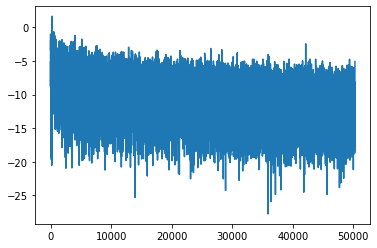

In [33]:
plt.plot(y.logits[0][0].cpu().numpy())

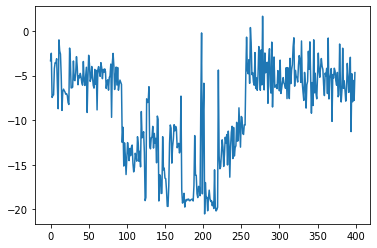

In [34]:
plt.plot(y.logits[0][0][range(0,400)].cpu().numpy())

Try to compare the pattern for 'ing' to the embedding matrix for 'ing'

In [35]:
y.hidden_states[11].shape

torch.Size([1, 14, 768])

y.hidden_states is a tuple - 1 element per layer. 
Each has 1 batch dim, 14 tokens, 768 weights. Look at the first token

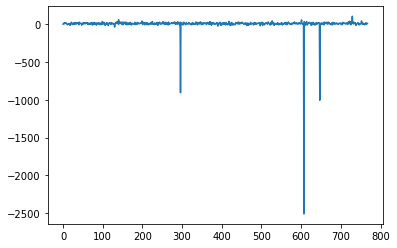

In [36]:
plt.plot(y['hidden_states'][11][0][0].cpu().numpy())

And look at the embedding row

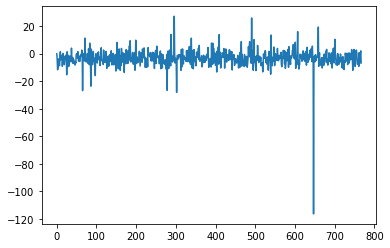

In [37]:
plt.plot(hidden_states['h.11'][0][0].cpu().numpy())

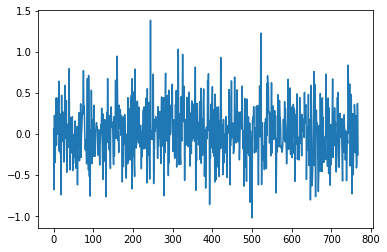

In [38]:
predicted_token_id = 278
plt.plot(model.lm_head.weight[predicted_token_id].cpu().detach().numpy())

No obvious similarity. Can we replicate how logits were generated from hidden layer 11?

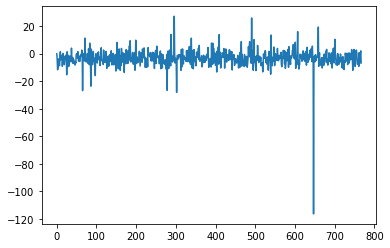

In [39]:
#tf_utils 
plt.plot(hidden_states['h.11'][0][0].cpu().detach().numpy())

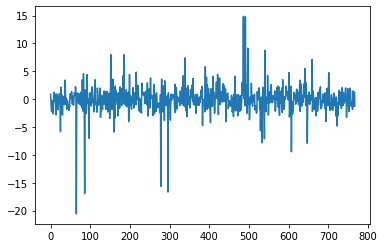

In [40]:
normed =model.base_model.ln_f(hidden_states['h.11'])
plt.plot(normed[0][0].cpu().detach().numpy())

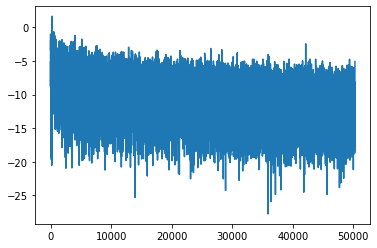

In [41]:
logits2 = model.lm_head(normed)
plt.plot(logits2[0][0].cpu().detach().numpy())

In [42]:
torch.argmax(logits2[0][0]), logits2[0][0][278]

(tensor(278, device='cuda:0'),
 tensor(1.6583, device='cuda:0', grad_fn=<SelectBackward>))

Above results (based on torch_utils) are same as those from huggingface. Can we do the same using vector alone?

In [43]:
v1 = model.base_model.wte.weight[278]
v2 = hidden_states['h.11'][0][0]
v1.shape, v2.shape, torch.dot(v1,v2)

(torch.Size([768]),
 torch.Size([768]),
 tensor(71.0902, device='cuda:0', grad_fn=<DotBackward>))

In [44]:
v1 = model.base_model.wte.weight[278]
v2 = normed[0][0]
v1.shape, v2.shape, torch.dot(v1,v2)

(torch.Size([768]),
 torch.Size([768]),
 tensor(1.6583, device='cuda:0', grad_fn=<DotBackward>))

My plan is to measure other hidden state vectors against the projection of v1 onto v2. v1 is the full embedding for the token 'ing'. v2 is a point in the final layer latent space which is closest to v1 so the projection from v1 ont v2 should represent information directly related to the prediction. I am interested in how much of v1 came from lower layers, and how much from attention (probably none in this case because it is the first token), and if anything carried through to later layers. 

First I want to understand norm better, then confirm whether attention made a contribution for this token, if so attention to what?

---

The norm function is layer norm, and earlier we applied to the entire layer. Are results altered if we apply it to a single vector?  

In [45]:
model.base_model.ln_f

LayerNorm((768,), eps=1e-05, elementwise_affine=True)

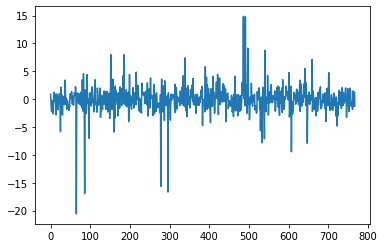

In [46]:
normv =model.base_model.ln_f(hidden_states['h.11'][0][0])
plt.plot(normed[0][0].cpu().detach().numpy())

Looks the same both in pattern and magnitude.

In [47]:
 torch.dot(v1,normv)

tensor(1.6583, device='cuda:0', grad_fn=<DotBackward>)

Same resulting logit element.

LayerNorm is described in https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, implemented in https://github.com/pytorch/pytorch/blob/c3d40fdf5658d8f4d387a39633c11bbb67b17224/aten/src/ATen/native/cuda/layer_norm_kernel.cu#L68 and based on https://arxiv.org/abs/1607.06450

Layer Normalisation re-centers and re-scales the activations of a layer. Given $a^t$ as the summed inputs to layer t, the hidden state of layer t $h^t$ is defined as

$$ h^t = f [ \frac{g}{\sigma^t} \odot ( a^t - \mu^t) + b]$$
where the mean activation is 
$$ \mu^t = \frac{1}{H} \sum_{i=1}^{H} a^t_i $$
and the variance is
$$ \sigma^t = \sqrt{\frac{1}{H} \sum_{i=1}^H (a^t_i - \mu^t)^2}$$

Weight $g$ and bias $b$ are learnable parameters, and $\odot$ is elementwise multiplication. All the hidden units in a layer share the same normalization terms $\mu$ and $\sigma$, but unlike batch normalisation different training cases have different normalization terms.

Based on the experiment above a layer here means a single embedding vector, rather than the layer of vectors across which attention is applied. 

---

Next to investigate if attention has much impact on the first prediction.

https://jalammar.github.io/illustrated-gpt2/ has a good high-level description of attention in GPT-style models.

From the huggingface version of modeling_gpt_neo GPTNeoBlock

hidden_states = (attn_output + residual) + mlp(ln_2(attn_output + residual)) where attn_output is GPTNeoAttention block applied to ln_2(input_hidden_state).
GPTNeoLocalSelfAttention
GPTNeoAttention implemented in either GPTNeoSelfAttention or GPTNeoLocalSelfAttention


In [48]:
model.base_model.h[11].attn.attention

GPTNeoLocalSelfAttention(
  (attn_dropout): Dropout(p=0, inplace=False)
  (resid_dropout): Dropout(p=0, inplace=False)
  (k_proj): Linear(in_features=0, out_features=768, bias=False)
  (v_proj): Linear(in_features=0, out_features=768, bias=False)
  (q_proj): Linear(in_features=0, out_features=768, bias=False)
  (out_proj): Linear(in_features=0, out_features=768, bias=True)
)

In [49]:
model.base_model.h[11].attn.attention.num_heads

12

From GPTNeoAttentionMixin.\_attn and GPTNeoLocalSelfAttention - the values added for output_attentions=True are attn_weights before multiplying by value matrix. 

In [50]:
len(y.attentions), y.attentions[11].shape

(12, torch.Size([1, 1, 12, 14, 270]))

In [51]:
inputs2=text_to_input_ids("Watch")
inputs2

tensor([[10723]], device='cuda:0')

In [52]:
with torch.no_grad():    
    y2 = model.forward(inputs2,output_attentions=False,
        output_hidden_states=True,
        return_dict=True)

y2.keys()

odict_keys(['logits', 'past_key_values', 'hidden_states'])

output_attentions does result in the attentions value in output dictionary. Reducing the number of input tokens...

In [53]:
with torch.no_grad():    
    y2 = model.forward(inputs2,output_attentions=True,
        output_hidden_states=True,
        return_dict=True)

y2.keys()

odict_keys(['logits', 'past_key_values', 'hidden_states', 'attentions'])

The predicted token is 278 'ing' as before.

In [54]:
len(y2.attentions), y2.attentions[11].shape, torch.argmax(y2.logits)

(12, torch.Size([1, 1, 12, 1, 257]), tensor(278, device='cuda:0'))

Lots of dimensions. Is the first 12 for the layers attention is applied for, second 12 the num heads?
From \_split\_heads the tensor dimensions could be (batch, blocks, head, block_length, head_features) - but what is blocks and block_length?


Looking at a couple of attention vectors, they have last element=1, rest=0.

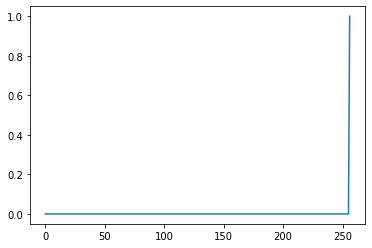

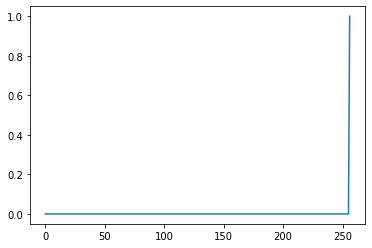

In [82]:
plt.plot(y2.attentions[11][0][0][11][0].cpu())
plt.show()

plt.plot(y2.attentions[3][0][0][8][0].cpu())
plt.show()


Checking same again for a later token in the transformer output generated from a phrase earlier.

In [56]:
len(y.attentions), y.attentions[11].shape

(12, torch.Size([1, 1, 12, 14, 270]))

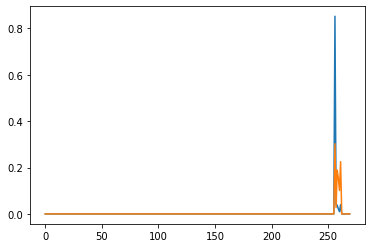

In [74]:
plt.plot(y.attentions[11][0][0][11][5].cpu())
plt.plot(y.attentions[3][0][0][8][5].cpu())

The vectors still look sparse, but have a few nonzero weights. Checking shape hasn't changed.

In [75]:
len(y2.hidden_states), y2.hidden_states[0].shape, len(y.hidden_states), y.hidden_states[0].shape,

(13, torch.Size([1, 1, 768]), 13, torch.Size([1, 14, 768]))

Look at the norm of activation weights in each head for first token position

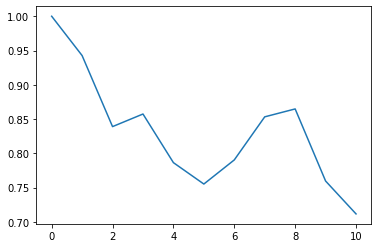

In [76]:
position0_last_layer_attention_vecs=y.attentions[11][0][0][0][range(0,11)].cpu().numpy()
plt.plot([np.linalg.norm(v) for v in position0_last_layer_attention_vecs])

Comparing against the norm of activation weights in each head for the next token position, different but nothing stands out

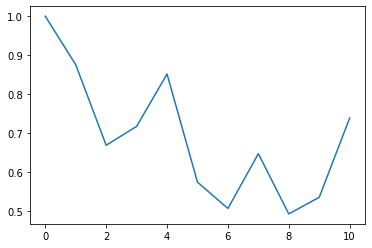

In [81]:
position1_last_layer_attention_vecs = y.attentions[11][0][0][1][range(0,11)]
position1_last_layer_attention_vecs = position1_last_layer_attention_vecs.cpu()
plt.plot([np.linalg.norm(v) for v in position1_last_layer_attention_vecs])

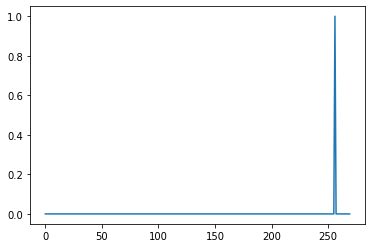

In [69]:
plt.plot(y.attentions[11][0][0][0][0].cpu())

----
Scratchpad Below
----

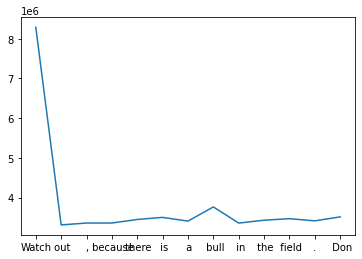

In [61]:
def compare(position):
    return torch.dot(y['hidden_states'][11][0][0], y['hidden_states'][11][0][position]).cpu().detach().numpy()

plt.plot([tokenizer.decode(input_ids[0][i]) for i in range(0,13)], [compare(pos) for pos in range(0,13)])


In [62]:
input_ids.shape

torch.Size([1, 14])

In [63]:
y['attentions'][11].shape

torch.Size([1, 1, 12, 14, 270])

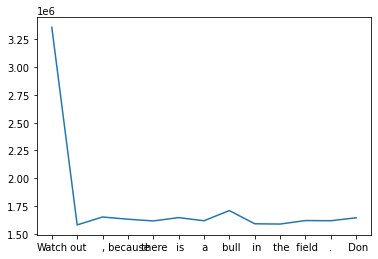

In [64]:
def compare(a,b):
    return torch.dot(y['hidden_states'][11][0][a], y['hidden_states'][11][0][b]).cpu().detach().numpy()

plt.plot([tokenizer.decode(input_ids[0][i]) for i in range(0,13)], [compare(2,pos) for pos in range(0,13)])


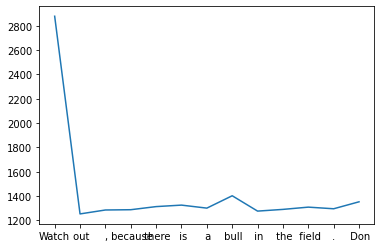

In [65]:
words = [tokenizer.decode(input_ids[0][i]) for i in range(0,13)]
norms = [torch.linalg.norm(y['hidden_states'][11][0][i]).cpu().numpy() for i in range(0,13)]
plt.plot(words,norms)

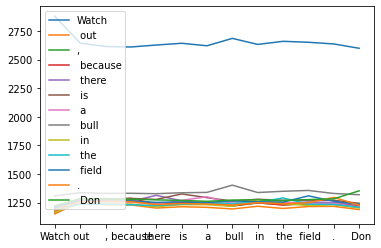

In [66]:
def project(x,y):
    return (torch.dot(x, y) / torch.linalg.norm(y)).cpu()
words =  [tokenizer.decode(input_ids[0][i]) for i in range(0,13)]

def against(posn):
    ref_vec = y['hidden_states'][11][0][posn]
    return plt.plot(words, [project(ref_vec, y['hidden_states'][11][0][i]) for i in range(0,13)], label=words[posn])

lines = []
for i in range(0,13):
    lines.extend(against(i))
plt.legend()
plt.show()


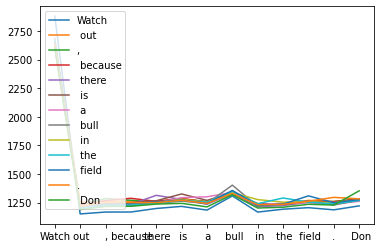

In [67]:
def against(posn):
    ref_vec = y['hidden_states'][11][0][posn]
    return plt.plot(words, [project( y['hidden_states'][11][0][i], ref_vec) for i in range(0,13)], label=words[posn])

lines = []
for i in range(0,13):
    lines.extend(against(i))
plt.legend()
plt.show()
